# ABC calibration of $I_\text{to}$ in Nygren model to unified dataset.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Wang1993]
 - Activation time constant [Courtemanche1998]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Wang1993]
 - Inactivation time constant [Courtemanche1998]
 - Recovery time constant [Courtemanche1998]

In [1]:
from experiments.ito_wang import wang_act, wang_inact
from experiments.ito_courtemanche import courtemanche_kin, courtemanche_rec, courtemanche_deact

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/nygren_ito.mmt'

Plot steady-state and time constant functions of original model

In [3]:
from ionchannelABC.visualization import plot_variables

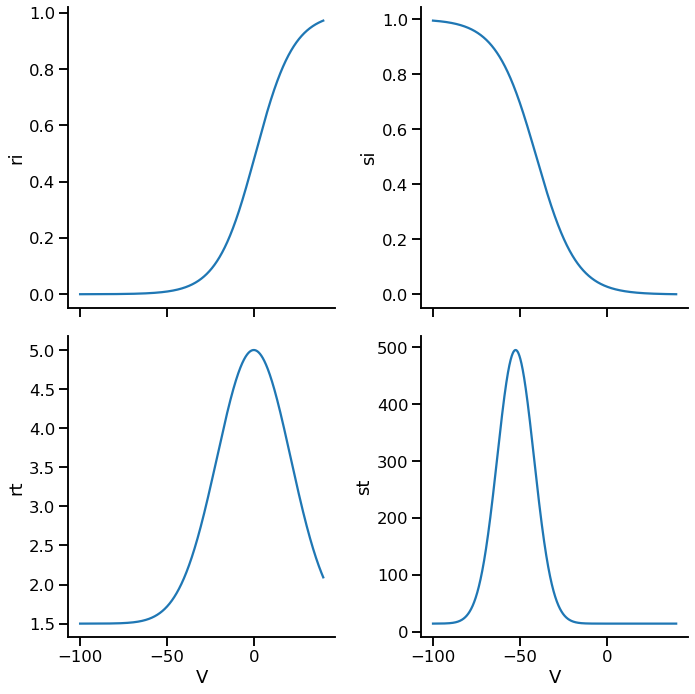

In [8]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

nyg_par_map = {'ri': 'ito.r_inf',
            'si': 'ito.s_inf',
            'rt': 'ito.tau_r',
            'st': 'ito.tau_s'}

f, ax = plot_variables(V, nyg_par_map, modelfile, figshape=(2,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act,
                                                wang_inact,
                                                courtemanche_kin,
                                                courtemanche_deact,
                                                courtemanche_rec)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


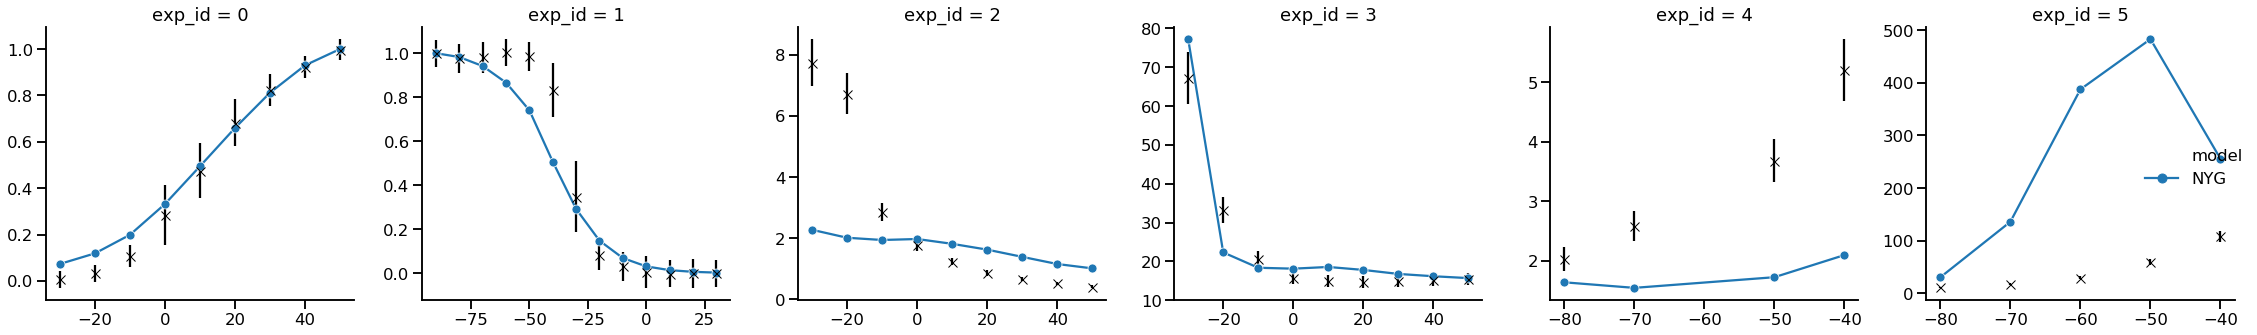

In [11]:
g = plot_sim_results(modelfile,
                     wang_act,
                     wang_inact,
                     courtemanche_kin,
                     courtemanche_deact,
                     courtemanche_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [12]:
limits = {'ito.p1': (-100, 100),
          'ito.p2': (1e-7, 50),
          'log_ito.p3': (-7, 0),
          'ito.p4': (1e-7, 50),
          'log_ito.p5': (-7, 0),
          'ito.q1': (-100, 100),
          'ito.q2': (1e-7, 50),
          'log_ito.q3': (-5, 1),
          'ito.q4': (-100, 100),
          'ito.q5': (1e-7, 50),
          'log_ito.q6': (-7, 0)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

## Run ABC-SMC inference

Set-up path to results database.

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ito_unified.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 2048 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.0858980949944816, '1': 1.0858980949944816, '2': 1.0858980949944816, '3': 0.4192258490995194, '4': 0.4514739913379436, '5': 0.5335601715812083, '6': 0.7825549183191034, '7': 1.0858980949944816, '8': 1.0858980949944816, '9': 0.6224264374795091, '10': 0.5705575676895505, '11': 0.526668524021124, '12': 0.6224264374795091, '13': 0.5705575676895536, '14': 0.3112132187397554, '15': 0.23609278663015926, '16': 0.5705575676895505, '17': 0.5705575676895563, '18': 0.5266685240211265, '19': 0.6224264374795127, '20': 0.5705575676895563, '21': 0.6224264374795127, '22': 0.5429490474972408, '23': 0.6248364448246935, '24': 1.0858980949944816, '25': 1.0858980949944816, '26': 1.0858980949944816, '27': 1.0858980949944816, '28': 1.0858980949944816, '29': 1.0858980949944816, '30': 1.0858980949944816, '31': 0.5429490474972408, '32': 1.0858980949944816, '33': 1.0858980949944816, '34': 1.0858980949944816, '35': 1.0858980949944816, '36': 1.0858980949944816, '37': 1.08589809

In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-23 06:32:39.651014, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


## Analysis of results

In [14]:
history = History('sqlite:///results/nygren/ito/unified/nygren_ito_unified.db')

In [15]:
df, w = history.get_distribution()

In [16]:
df.describe()

name,ito.p1,ito.p2,ito.p4,ito.q1,ito.q2,ito.q4,ito.q5,log_ito.p3,log_ito.p5,log_ito.q3,log_ito.q6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.934423,2.186713,43.605047,29.153406,1.240922,38.171150,16.916623,-2.091963,-2.907878,-1.042483,-2.067621
std,2.557482,0.504456,1.502141,1.004034,0.491308,0.288022,0.414204,0.022598,0.027901,0.013621,0.012372
min,-8.767451,0.726912,39.025898,26.325026,0.085213,37.329333,15.507728,-2.148320,-3.005758,-1.083289,-2.106856
25%,-2.020498,1.923300,42.561815,28.402685,0.888874,37.974958,16.626566,-2.108361,-2.926502,-1.052076,-2.075759
50%,-0.401735,2.186964,43.662580,28.966786,1.209313,38.168064,16.897294,-2.093955,-2.907251,-1.042567,-2.067384
75%,0.690785,2.409651,44.648404,30.097347,1.537878,38.367858,17.203984,-2.077272,-2.887848,-1.033378,-2.059400
max,6.266433,5.013096,47.806825,32.065177,3.345243,38.997243,18.171541,-2.015264,-2.827305,-1.000574,-2.024777


### Plot summary statistics compared to calibrated model output.

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


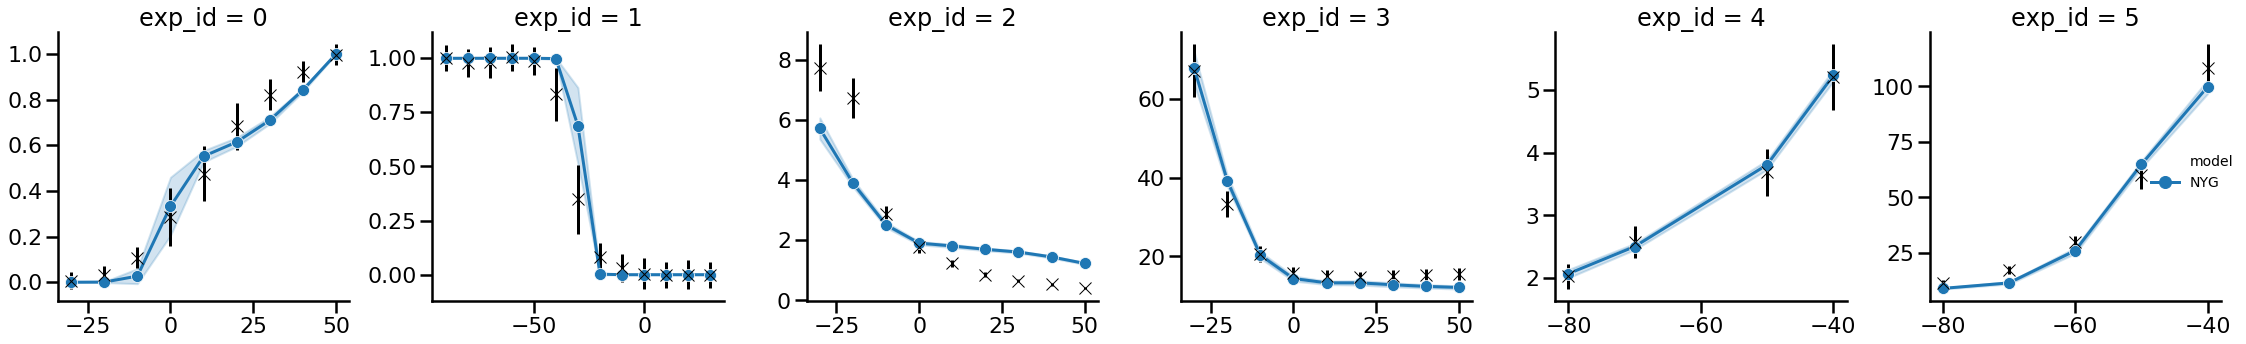

In [17]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     wang_act,
                     wang_inact,
                     courtemanche_kin,
                     courtemanche_deact,
                     courtemanche_rec,
                     df=df, w=w)

plt.tight_layout()

### Plot gating functions

In [18]:
import pandas as pd
N = 100
nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

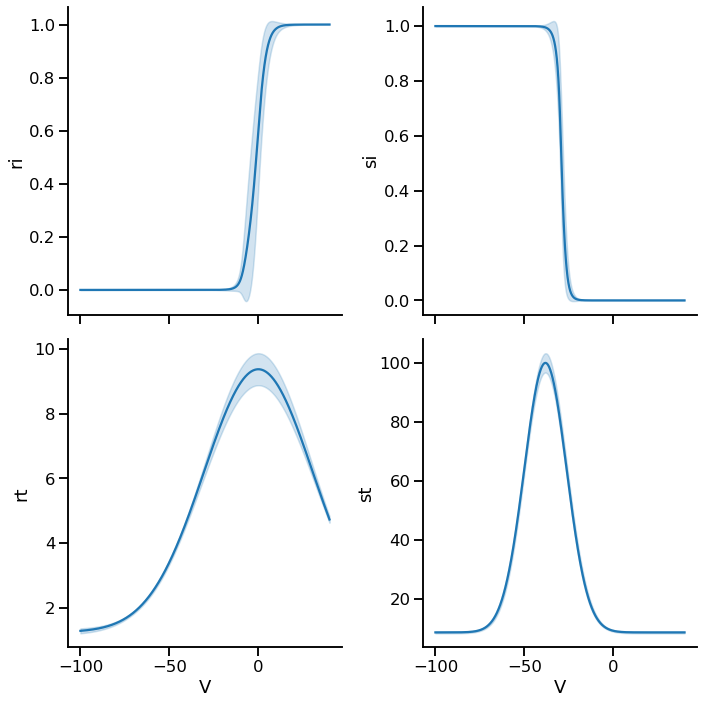

In [19]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ito.mmt', 
                       [nyg_par_samples],
                       figshape=(2,2))

### Plot parameter posteriors

In [20]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [21]:
m,_,_ = myokit.load(modelfile)

In [22]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

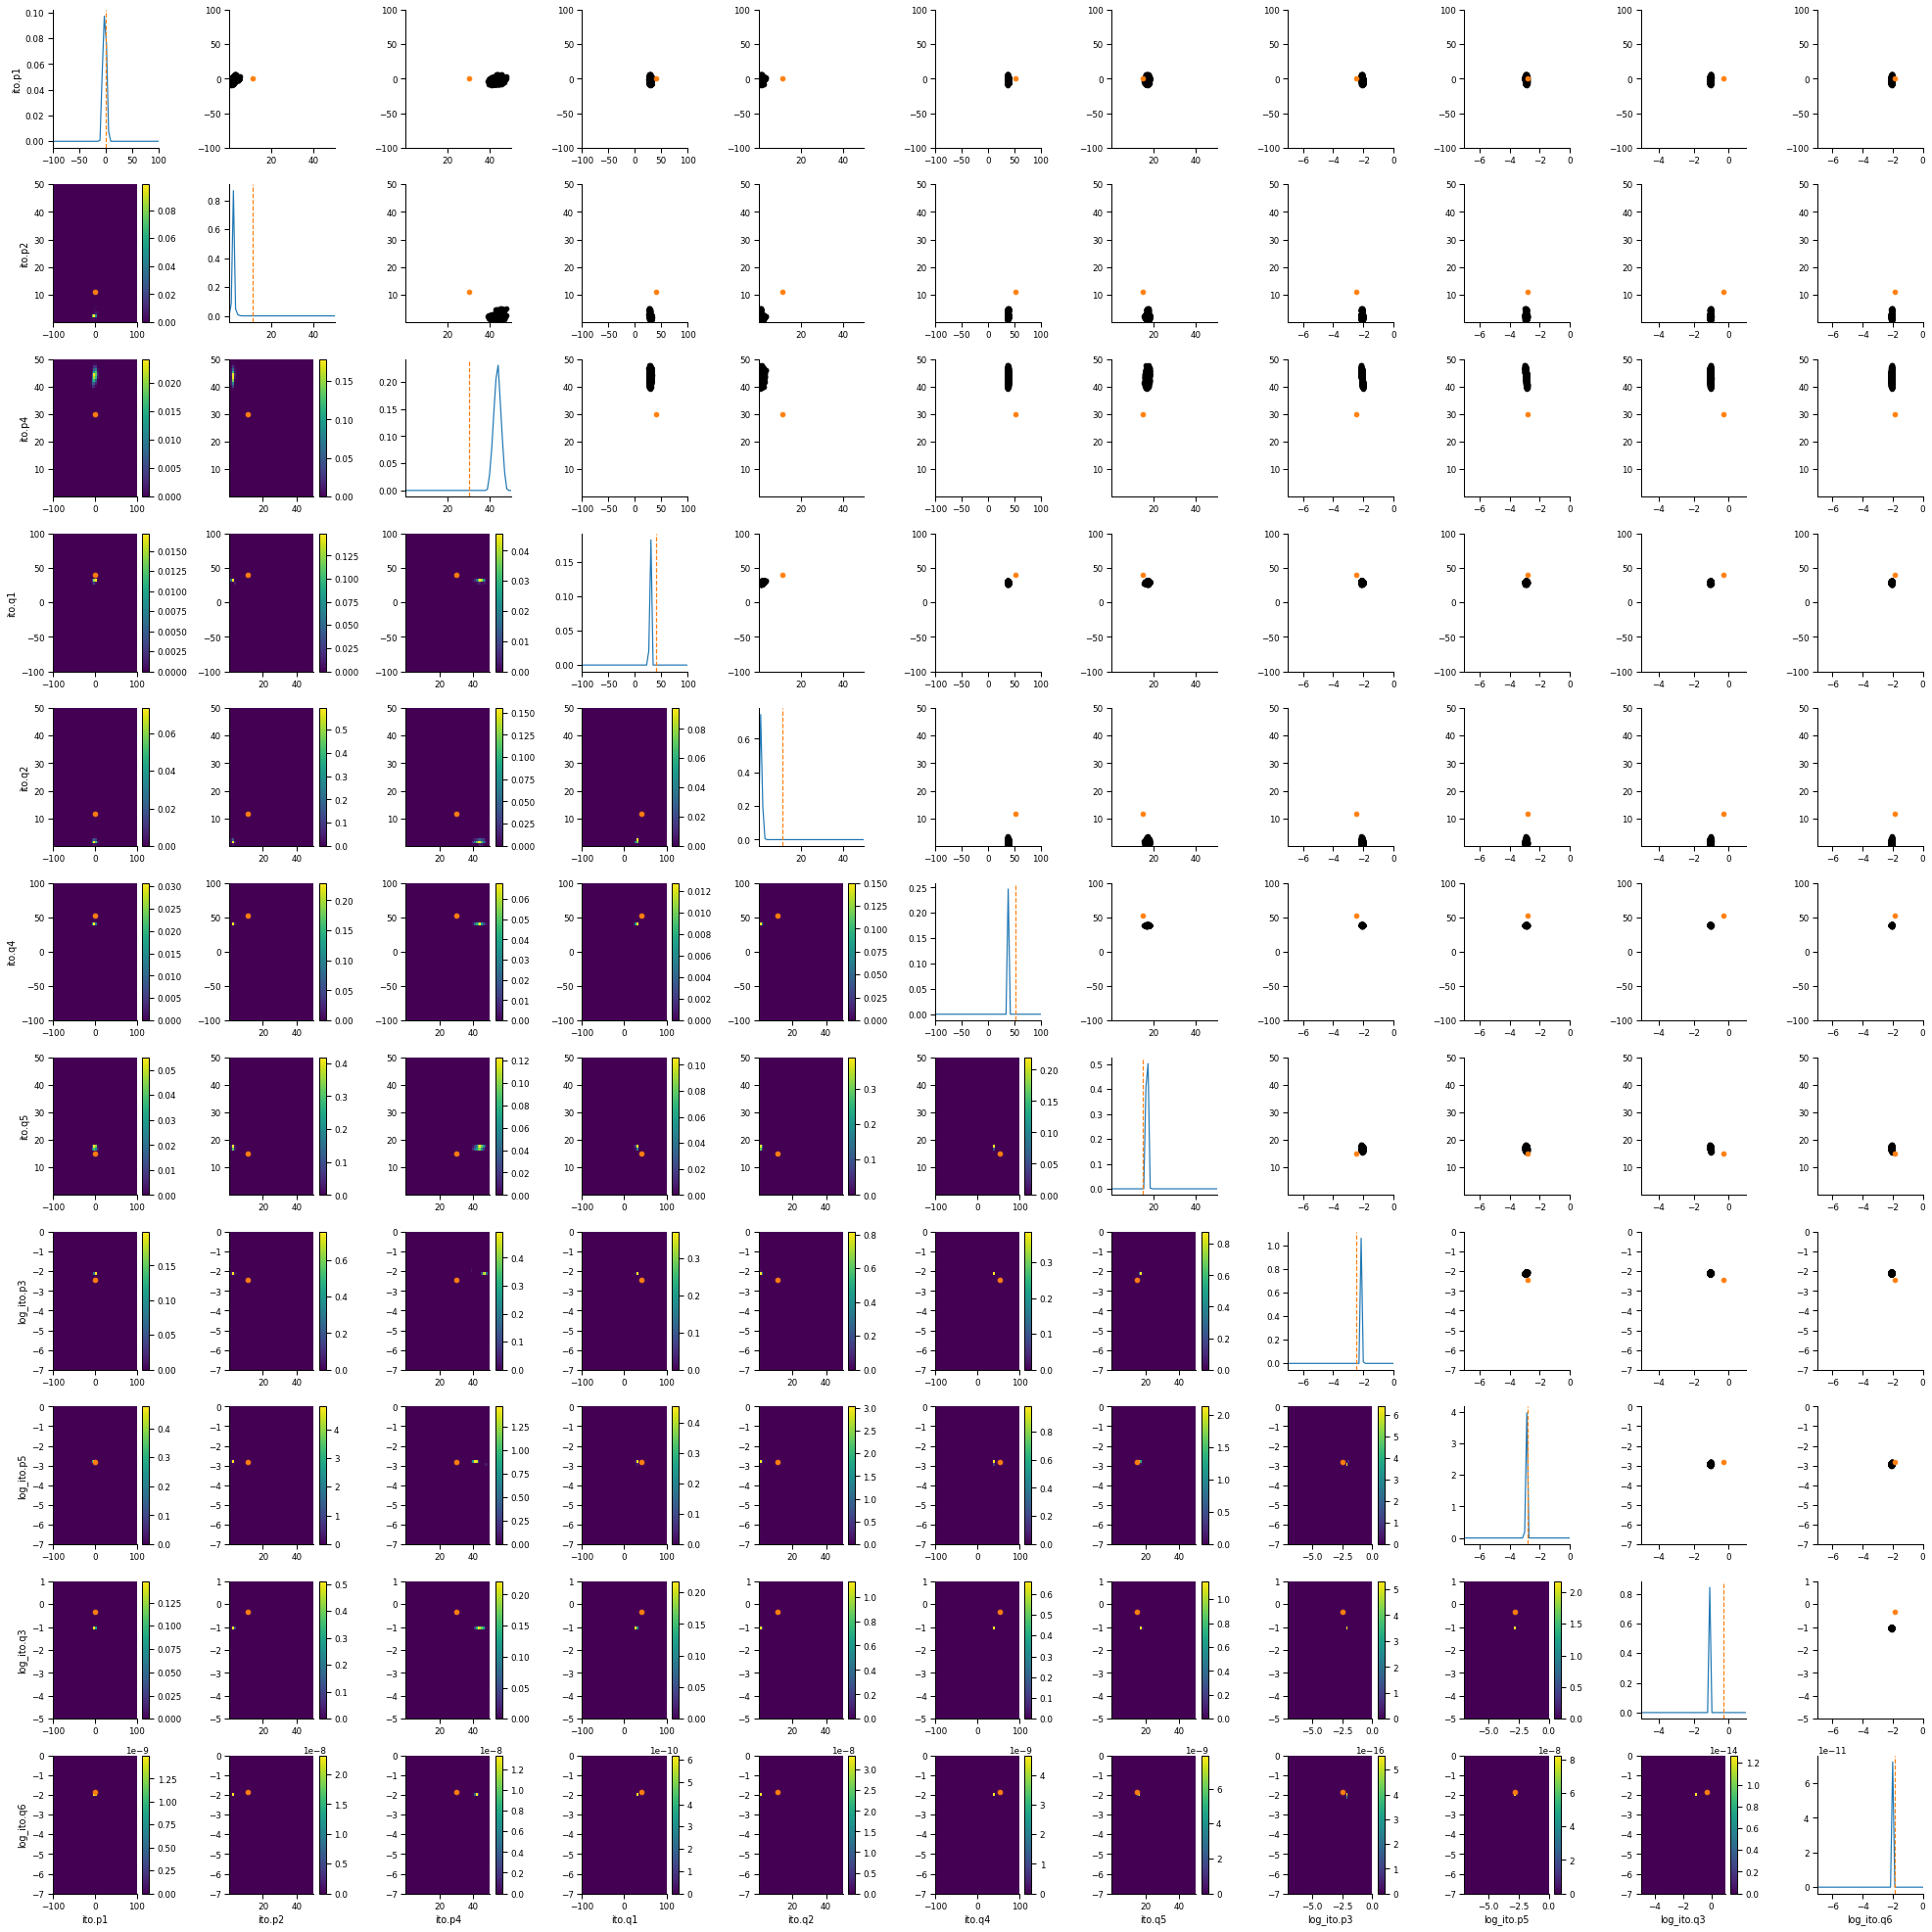

In [23]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()